# Introduction #

This project provides an easy to use functionality to implement and evaluate automatic stock trading strategies. It is implemented in java and therefore can be used in any environment which builds on the JVM.

It provides the following functionality:
- Simple access to stock data
- Declarative formulation of trading strategies
- Evaluation of trading strategies
- Optimization of trading strategies
- Support of portfolio of multiple stocks / trading strategies

At the end it should be possible to easily formulate and evaluate stock strategy and to evaluate
the impact of changes on assumptions.

In this document we demonstrates the basic functionality using Scala: We are using JupyterLab (http://jupyter.org) with the BeakerX (http://beakerx.com/) Scala Kernel.

## Setup ##
We need to add the java libraries:

In [1]:
%classpath config resolver maven-public http://software.pschatzmann.ch/repository/maven-public/
%classpath add mvn ch.pschatzmann:investor:0.9-SNAPSHOT
%classpath add mvn ch.pschatzmann:jupyter-jdk-extensions:0.0.1-SNAPSHOT


Added new repo: maven-public


### Imports ###

First we define all the imports which are used in this demo:

In [2]:
// our stock evaluation framwork
import ch.pschatzmann.dates._;
import ch.pschatzmann.stocks._;
import ch.pschatzmann.stocks.data.universe._;
import ch.pschatzmann.stocks.input._;
import ch.pschatzmann.stocks.accounting._;
import ch.pschatzmann.stocks.accounting.kpi._;
import ch.pschatzmann.stocks.execution._;
import ch.pschatzmann.stocks.execution.fees._;
import ch.pschatzmann.stocks.execution.price._;
import ch.pschatzmann.stocks.parameters._;
import ch.pschatzmann.stocks.strategy._;
import ch.pschatzmann.stocks.strategy.optimization._;
import ch.pschatzmann.stocks.strategy.allocation._;
import ch.pschatzmann.stocks.strategy.selection._;
import ch.pschatzmann.stocks.integration._;
import ch.pschatzmann.stocks.integration.ChartData.FieldName._;
import ch.pschatzmann.stocks.strategy.OptimizedStrategy.Schedule._;


// java
import java.util.stream.Collectors;
import java.util._;
import java.lang._;
import java.util.function.Consumer;

// ta4j
import org.ta4j.core._;
import org.ta4j.core.analysis._;
import org.ta4j.core.analysis.criteria._;
import org.ta4j.core.indicators._;
import org.ta4j.core.indicators.helpers._;
import org.ta4j.core.trading.rules._;

// jupyter custom displayer
import ch.pschatzmann.display.Displayers

import ch.pschatzmann.dates._
import ch.pschatzmann.stocks._
import ch.pschatzmann.stocks.data.universe._
import ch.pschatzmann.stocks.input._
import ch.pschatzmann.stocks.accounting._
import ch.pschatzmann.stocks.accounting.kpi._
import ch.pschatzmann.stocks.execution._
import ch.pschatzmann.stocks.execution.fees._
import ch.pschatzmann.stocks.execution.price._
import ch.pschatzmann.stocks.parameters._
import ch.pschatzmann.stocks.strategy._
import ch.pschatzmann.stocks.strategy.optimization._
import ch.pschatzmann.stocks.strategy.allocation._
import ch.pschatzmann.stocks.strategy.selection._
import ch.pschatzmann.stocks.integration._
import ch.pschatzmann.stocks.integration.ChartData.FieldName._
import ch.pschatzmann.stocks.strategy.OptimizedStrategy.Schedule._
import java.util.stream...

We register the automatic displayers for charts. We are also not interested in information messages from the log, so we define a higher log level:


In [3]:
Displayers.setup("WARN")


true


## Basic Data Structures: Universe, StockID, StockData ##

A StockID is identifiying a stock by the trading symbol and the exchange.

The Uninverse is a collection of StockIDs. We can use the universe to find stocks or to process a collection relevant stocks.
- QuandlWIKIUniverse
- QuandlSixUniverse
- QuandlEuronextUniverse
- MarketUniverse
- JsonUniverse
- ListUniverse

In [4]:
var universe = new ListUniverse(Arrays.asList(new StockID("AAPL","NASDAQ")));
var values = universe.list();

Displayers.display(values)


ticker,exchange
AAPL,NASDAQ


In [5]:
var universe = new QuandlSixUniverse();
var values = Context.head(universe.list(),10);

Displayers.display(values)


ticker,exchange
ARP290071876CHF,SIX
AN8068571086CHF,SIX
AT0000652011CHF,SIX
AT0000741053CHF,SIX
AT0000606306CHF,SIX
AT0000676903CHF,SIX
AT0000743059CHF,SIX
AT0000644505CHF,SIX
AT0000720008CHF,SIX
AT0000697750CHF,SIX


Just as a side note: The API provides java collections. It is possible to convert them to a Scala type -  e.q a Seq.


In [6]:
var universe = new IEXUniverse();
var values = Context.head(universe.list(),10);

Displayers.display(values)


ticker,exchange
A,
AA,
AABA,
AAC,
AADR,
AAL,
AAMC,
AAME,
AAN,
AAOI,


In [7]:
import scala.collection.JavaConverters;

JavaConverters.asScalaBufferConverter(values).asScala.toSeq

[[:A, :AA, :AABA, :AAC, :AADR, :AAL, :AAMC, :AAME, :AAN, :AAOI]]

The StockData is the class which provides the history of stock rates and some stock related KPIs. We need to indicate a Reader which defines the source of the data. 

Currently we support
- YahooReader
- QuandlWIKIReader
- QuandlSixReader
- MarketArchiveHttpReader
- AlphaVantageReader
- IEXReader

Here is the example how to retrieve the stock history:

In [8]:
var stockdata = new StockData(new StockID("AAPL", "NASDAQ"), new IEXReader());

Displayers.display(Context.tail(stockdata.getHistory(),10));


index,date,low,high,open,closing,adjustmentFactor,volume
1248,2018-05-14,187.86,,189.01,188.15,,20778772
1249,2018-05-15,185.1,,186.78,186.44,,23695159
1250,2018-05-16,186,,186.07,188.18,,19183064
1251,2018-05-17,186.36,,188,186.99,,17294029
1252,2018-05-18,186.13,,187.19,186.31,,18297728
1253,2018-05-21,186.9106,,188,187.63,,18400787
1254,2018-05-22,186.78,,188.375,187.16,,15240704
1255,2018-05-23,185.76,,186.35,188.36,,20058415
1256,2018-05-24,186.21,,188.77,188.15,,23233975
1257,2018-05-25,187.65,,188.23,188.58,,17460963


## Charts ##
Unfortunatly the BeakerX charting currently does not work in Jupyterlab. Therfore we use JFeeChart http://www.jfree.org/jfreechart/. 

Now, we can display a stock chart in just 1 line:


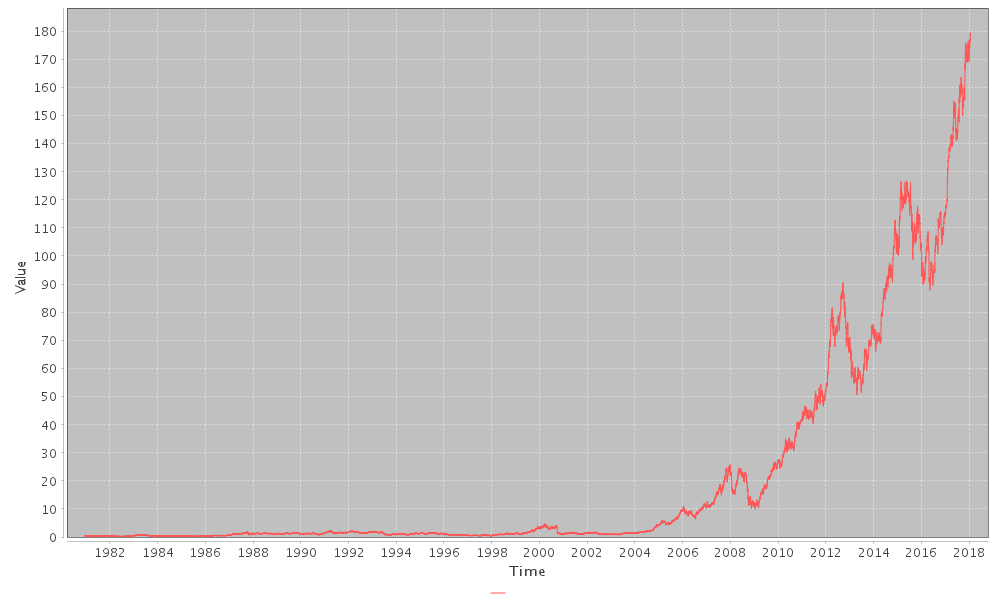

In [9]:
var aapl = new StockData(new StockID("AAPL", "NASDAQ"), new MarketArchiveHttpReader());
new TimeSeriesChart().add(aapl)

## Technical Analysis with TA4J ##

Ta4j is an open source Java library for technical analysis. It provides the basic components for creation, evaluation and execution of trading strategies.

We can use our StockData functionality as data source for TA4J to e.g. to calculate indicators:


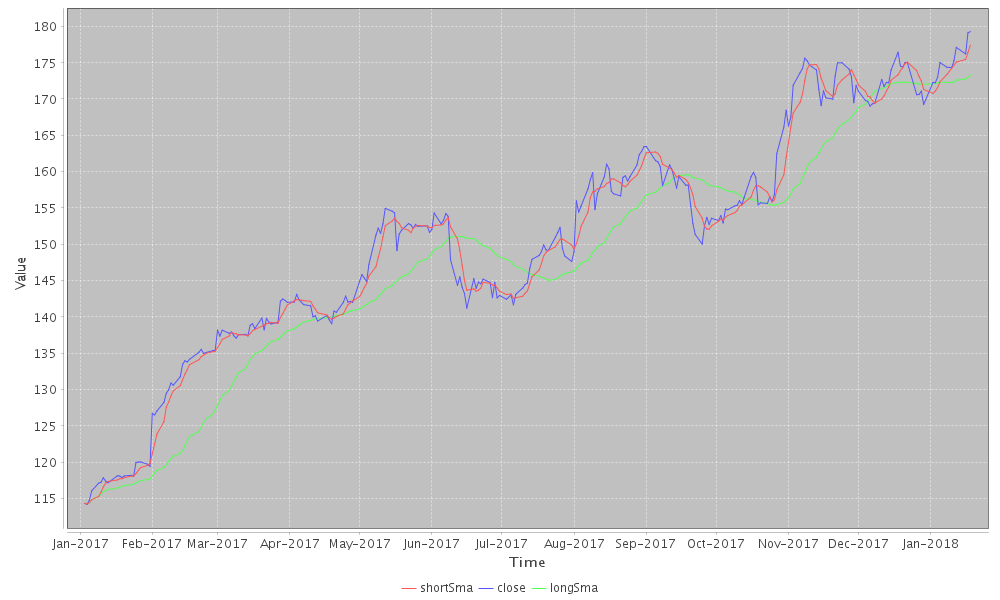

In [10]:
var stockData:IStockData = new StockData(new StockID("AAPL", "NASDAQ"), new MarketArchiveHttpReader());
// translate to Ta4j TimeSeries
var series = new Ta4jTimeSeries(stockData, new DateRange(Context.date("2017-01-01"),new Date()));
// Closing Prices
var closePrice:Indicator[Decimal] = new ClosePriceIndicator(series);
// Getting the simple moving average (SMA) of the close price over the last 5 ticks
var shortSma:Indicator[Decimal] = new SMAIndicator(closePrice, 5);
// Getting a longer SMA (e.g. over the 30 last ticks)
var longSma:Indicator[Decimal] = new SMAIndicator(closePrice, 30);

// create chart
var chart = new TimeSeriesChart()
chart.add(shortSma,"shortSma")
chart.add(closePrice,"close")
chart.add(longSma,"longSma")

chart

## Trading with TA4J ##

Here is the complete trading and evaluation example which we took from the TA4J documentation that can be found at
https://github.com/ta4j/ta4j/wiki/Getting%20started.

The example has been converted to Scala:

In [11]:
var stockData = new StockData(new StockID("AAPL", "NASDAQ"), new MarketArchiveHttpReader());
var series = new Ta4jTimeSeries(stockData);
var closePrice = new ClosePriceIndicator(series);

// Getting the simple moving average (SMA) of the close price over the last 5 ticks
var shortSma = new SMAIndicator(closePrice, 5);
// Getting a longer SMA (e.g. over the 30 last ticks)
var longSma = new SMAIndicator(closePrice, 30);

// Buying rules
// We want to buy:
//  - if the 5-ticks SMA crosses over 30-ticks SMA
//  - or if the price goes below a defined price (e.g $800.00)
var buyingRule = new CrossedUpIndicatorRule(shortSma, longSma)
        .or(new CrossedDownIndicatorRule(closePrice, Decimal.valueOf("800")));

// Selling rules
// We want to sell:
//  - if the 5-ticks SMA crosses under 30-ticks SMA
//  - or if if the price looses more than 3%
//  - or if the price earns more than 2%
var sellingRule = new CrossedDownIndicatorRule(shortSma, longSma)
        .or(new StopLossRule(closePrice, Decimal.valueOf("3")))
        .or(new StopGainRule(closePrice, Decimal.valueOf("2")));

var strategy = new BaseStrategy(buyingRule, sellingRule);
                                     
// Running our juicy trading strategy...
var manager = new TimeSeriesManager(series);
var tradingRecord = manager.run(strategy);
println("Number of trades for our strategy: " + tradingRecord.getTradeCount());
                                     
// Getting the cash flow of the resulting trades
var cashFlow = new CashFlow(series, tradingRecord);

// Getting the profitable trades ratio
var profitTradesRatio = new AverageProfitableTradesCriterion();
println("Profitable trades ratio: " + profitTradesRatio.calculate(series, tradingRecord));

// Getting the reward-risk ratio
var rewardRiskRatio = new RewardRiskRatioCriterion();
println("Reward-risk ratio: " + rewardRiskRatio.calculate(series, tradingRecord));

// Total profit of our strategy
// vs total profit of a buy-and-hold strategy
var vsBuyAndHold = new VersusBuyAndHoldCriterion(new TotalProfitCriterion());
println("Our profit vs buy-and-hold profit: " + vsBuyAndHold.calculate(series, tradingRecord));

"--END--"

Number of trades for our strategy: 218
Profitable trades ratio: 0.536697247706422
Reward-risk ratio: 1.8774625448568232
Our profit vs buy-and-hold profit: 0.0019066141135999938


--END--

So far we have seen how we can use our functionality toghether with TA4J to implement an automatic trading and evaluation platform. 

In the next Chapter we demonstrate our own Trading Simulation and Optimization functionality. 

## Accounts and Paper Trader##

The Account class is used to record and evaluate trades. We need to indicate the opening amount, the open date of the account and the Fees Model (IFeesModel). 
We can optionally register a generic reader or a ticker specific reader which defines from where the stock  information is read.

The requested stock trades are recorded with the addTransaction() method. Positive quantities are purchased, negative quantities are sold.

The paper trader implements the basic trading (simulation) functionality. We can indicate a delay (with setDelay() and the price logic with setPrice(). In our example the trade is executed on the next day with the open rate.

With the execute() method we start the processing which is processing the open unfilled orders.


In [12]:
var stockdata = new StockID("AAPL", "NASDAQ");
var account = new Account("Simulation","USD", 100000.00, Context.date("2015-01-01"), new PerTradeFees(10.0));

account.putReader(new MarketArchiveHttpReader());
account.addTransaction(new Transaction(Context.date("2015-01-04"), stockdata, +100l));
account.addTransaction(new Transaction(Context.date("2015-10-04"), stockdata, -90l));

var trader = new PaperTrader(account);
// configure alternative logic
trader.setDelay(new OneDayDelay());
trader.setPrice(new OpenPrice());
trader.execute();

// display the resulting transactions
Displayers.display(account.getTransactions());


active stockID date quantity requestedPrice filledPrice fees comment id impactOnCash buyOrSell requestedPriceType true Key Value ticker Cash exchange Account 2015-01-01 0 0 0 0 7217808a-02f5-4204-8c33-0ffb74e1e423 100000 NA CashTransfer true Key Value ticker AAPL exchange NASDAQ 2015-01-05 100 0 102.5099 10 d8590f3b-7f8c-4795-8eaa-a01e73ce0f91 -10260.9933 Buy Market true Key Value ticker AAPL exchange NASDAQ 2015-10-05 -90 0 105.3364 10 fd1bd3ec-b5fb-4a86-8521-84e9c20d9d2a 9470.2776 Sell Market

## Trading Strategies ##

The heart of automatic trading are the "trading strategies". A class which implements ITradingStrategy can be used for automatic trading. A class which implements IOptimizableTradingStrategy can be used for automatic parameter optimization and automatic trading. 

The framework comes with the following standard strategies:


In [13]:
TradingStrategyFactory.list()

[CCICorrectionStrategy, GlobalExtremaStrategy, MovingMomentumStrategy, RSI2Strategy, BuyAndHoldStrategy]

The Fitness class will be used to evaluate the strategies. As a result it provides both the input and the calculated KPI ouput parameters and updates the account.

You can use the SimulatedFitness class if you want to avoid the update to the account.

In [14]:
Displayers.display(account.getTransactions().collect(Collectors.toList()))

active stockID date quantity requestedPrice filledPrice fees comment id impactOnCash buyOrSell requestedPriceType true Key Value ticker Cash exchange Account 2015-01-01 0 0 0 0 7217808a-02f5-4204-8c33-0ffb74e1e423 100000 NA CashTransfer true Key Value ticker AAPL exchange NASDAQ 2015-01-05 100 0 102.5099 10 d8590f3b-7f8c-4795-8eaa-a01e73ce0f91 -10260.9933 Buy Market true Key Value ticker AAPL exchange NASDAQ 2015-10-05 -90 0 105.3364 10 fd1bd3ec-b5fb-4a86-8521-84e9c20d9d2a 9470.2776 Sell Market

In [15]:
var account = new Account("Simulation","USD", 100000.00, Context.date("2015-01-01"), new PerTradeFees(10.0));
var stockdata = new StockData(new StockID("AAPL", "NASDAQ"), new MarketArchiveHttpReader());
var strategy = new RSI2Strategy(stockdata);
var trader = new PaperTrader(account);
var state = new Fitness(trader).getFitness(strategy, account.getDateRange());

// print one parameter
println("Return: " + state.result().getValue(KPI.AbsoluteReturn));

// print all parameters
Displayers.display(state.result().getParameters())

Return: 56741.0


Key,Value
ReturnPercentAnualized,19
NumberOfTrades,5
SharpeRatio,1
MaxDrawDownPercent,33517
PurchasedValue,92884
ReturnPurcentStdDev,0
RealizedGains,-7066
NumberOfBuys,3
TotalFees,50
AbsoluteReturn,56741


In [16]:
Displayers.display(account.getTransactions())

active stockID date quantity requestedPrice filledPrice fees comment id impactOnCash buyOrSell requestedPriceType true Key Value ticker Cash exchange Account 2015-01-01 0 0 0 0 1af70412-cea9-4c63-a3ad-5e6ba047f31b 100000 NA CashTransfer true Key Value ticker AAPL exchange NASDAQ 2015-01-12 966 0 103.4187 10 1e16cf8a-81fb-4115-8bff-6e65abc38749 -99912.458 Buy Market true Key Value ticker AAPL exchange NASDAQ 2015-08-17 -966 0 112.3154 10 5bf75205-f175-4760-9ec9-6a8402bd5219 108486.6756 Sell Market true Key Value ticker AAPL exchange NASDAQ 2016-04-15 1020 0 106.3323 10 c4543d5d-108e-4383-8088-d723dab52bfd -108468.9442 Buy Market true Key Value ticker AAPL exchange NASDAQ 2016-05-10 -1020 0 90.979 10 3fbc5afb-00f2-49ca-bce4-364a77cbe0b1 92788.5762 Sell Market true Key Value ticker AAPL exchange NASDAQ 2016-08-11 878 0 105.6793 10 58710958-a9ac-49eb-861f-9ec8b66d5988 -92796.3972 Buy Market


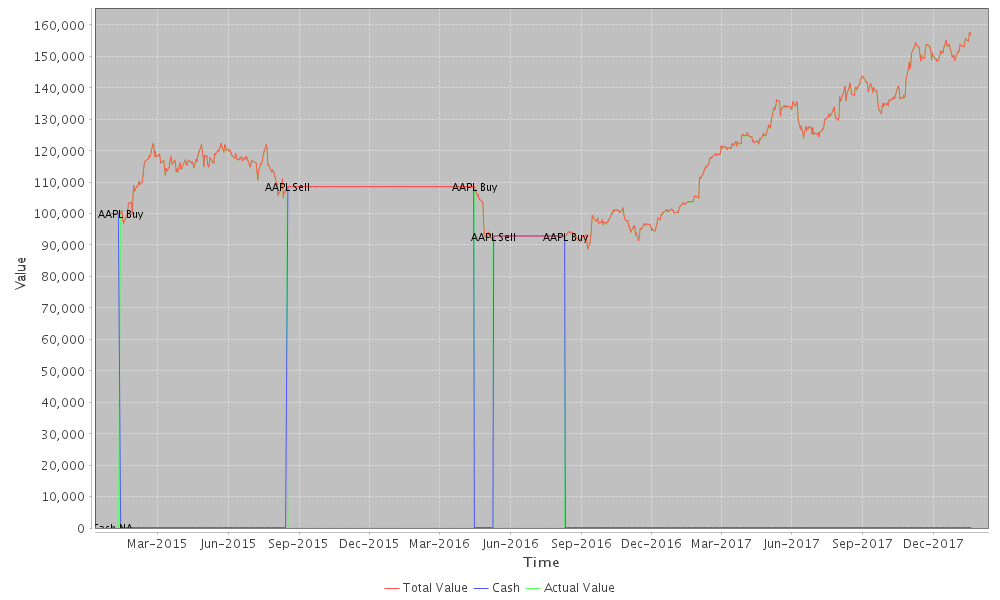

In [17]:
// create chart for total values
var chart = new TimeSeriesChart();
chart.add(account.getTotalValueHistory(), "Total Value")
chart.add(account.getCashHistoryForAllDates(), "Cash")
chart.add(account.getActualValueHistory(), "Actual Value")
chart.addLabels(account.getTransactions())

chart

In order to get a better understanding of the development of the values over time we can 
chart the Acocunt information.

In [18]:
Displayers.display(account.getTransactions())

active stockID date quantity requestedPrice filledPrice fees comment id impactOnCash buyOrSell requestedPriceType true Key Value ticker Cash exchange Account 2015-01-01 0 0 0 0 1af70412-cea9-4c63-a3ad-5e6ba047f31b 100000 NA CashTransfer true Key Value ticker AAPL exchange NASDAQ 2015-01-12 966 0 103.4187 10 1e16cf8a-81fb-4115-8bff-6e65abc38749 -99912.458 Buy Market true Key Value ticker AAPL exchange NASDAQ 2015-08-17 -966 0 112.3154 10 5bf75205-f175-4760-9ec9-6a8402bd5219 108486.6756 Sell Market true Key Value ticker AAPL exchange NASDAQ 2016-04-15 1020 0 106.3323 10 c4543d5d-108e-4383-8088-d723dab52bfd -108468.9442 Buy Market true Key Value ticker AAPL exchange NASDAQ 2016-05-10 -1020 0 90.979 10 3fbc5afb-00f2-49ca-bce4-364a77cbe0b1 92788.5762 Sell Market true Key Value ticker AAPL exchange NASDAQ 2016-08-11 878 0 105.6793 10 58710958-a9ac-49eb-861f-9ec8b66d5988 -92796.3972 Buy Market

### Trading Strategies Description ###

In [19]:
import scala.collection.JavaConversions._

var list = new ArrayList[HashMap[String,String]]()
for (strategy <-  TradingStrategyFactory.list()) {
    var map = new HashMap[String,String]();
    map.put("Name", strategy)
    map.put("Description",TradingStrategyFactory.getStrategyDesciption(strategy))
    list.add(map)
}

Displayers.display(list)

Description,Name
"Developed by Donald Lambert, the Commodity Channel Index (CCI) is a momentum oscillator that can be used to identify a new trend or warn of extreme conditions. This strategy uses weekly CCI to dictate the trading bias when it surges above +100 or plunges below -100, which are key levels noted by Lambert. Once the trading bias is set, daily CCI is used to generate trading signals when it reaches its extremes. Details can be found in stockcharts",CCICorrectionStrategy
This strategy compares the current price to the global extrema over a week. We ar going long if the close price goes below the minimum price. We are going short if the close price goes above the maximum price.,GlobalExtremaStrategy
"Many trading strategies are based on a process, not a single signal. This process often involves a series of steps that ultimately lead to a signal. Typically, chartists first establish a trading bias or long-term perspective. Second, chartists wait for pullbacks or bounces that will improve the risk-reward ratio. Third, chartists look for a reversal that indicates a subsequent upturn or downturn in price. The strategy put forth here uses moving average to define the trend, the Stochastic Oscillator to identify corrections within that trend and the MACD-Histogram to signal short-term reversals. It is a complete strategy based on a three step process. http://stockcharts.com/school/doku.php?id=chart_school:trading_strategies:moving_momentum",MovingMomentumStrategy
"Developed by Larry Connors, the 2-period RSI strategy is a mean-reversion trading strategy designed to buy or sell securities after a corrective period. The strategy is rather simple. Connors suggests looking for buying opportunities when 2-period RSI moves below 10, which is considered deeply oversold. Conversely, traders can look for short-selling opportunities when 2-period RSI moves above 90. This is a rather aggressive short-term strategy designed to participate in an ongoing trend. It is not designed to identify major tops or bottoms. Before looking at the details, note that this article is designed to educate chartists on possible strategies. We are not presenting a stand-alone trading strategy that can be used right out of the box. Instead, this article is meant to enhance strategy development and refinement. See http://stockcharts.com/school/doku.php?id=chart_school:trading_strategies:rsi2.",RSI2Strategy
We buy the title when the account is opened and hold the stock. This strategy can be used as a baseline to compare the other strategies.,BuyAndHoldStrategy


## Comparing Trading Strategies ##

Here is a small example which compares the trading strategies for Apple starting from 2015-01-01


In [20]:
import java.util.ArrayList

def calculateResult(account:Account, strategy : IOptimizableTradingStrategy) : java.util.Map[String,Object] = {
    var state = new SimulatedFitness(account).getFitness(strategy, account.getDateRange());
    var result = state.getMap();
    // add strategy name to result
    result.put("Strategy", strategy.getClass().getSimpleName());
    return result;
}

var account = new Account("Simulation","USD", 100000.00, Context.date("2015-01-01"), new PerTradeFees(10.0));
var sd = Context.getStockData("AAPL", "NASDAQ");

var result = new ArrayList[java.util.Map[String,Object]]();
result.add(calculateResult(account, new RSI2Strategy(sd)));
result.add(calculateResult(account, new BuyAndHoldStrategy(sd)));
result.add(calculateResult(account, new CCICorrectionStrategy(sd)));
result.add(calculateResult(account, new GlobalExtremaStrategy(sd)));
result.add(calculateResult(account, new MovingMomentumStrategy(sd)));

Displayers.display(result)

PurchasedValue,SharpeRatio,RealizedGains,UnrealizedGains,LongSMAPeriod,Cash,MaxDrawDownLowValue,NumberOfTrades,NumberOfTradedStocks,EntryLimit,RSIPeriod,NumberOfCashTransfers,AbsoluteReturnAvaragePerDay,NumberOfSells,MaxDrawDownHighValue,ShortSMAPeriod,ReturnPercentAnualized,AbsoluteReturnStdDev,ExitLimit,AbsoluteReturn,NumberOfBuys,ReturnPercent,TotalFees,MaxDrawDownNumberOfDays,ActualValue,MaxDrawDownPercent,ReturnPurcentStdDev,Strategy
92884,1,-7066,63858,200,97,88757,5,1,5,2,1,74,2,122274,5,19,1235,95,56741,3,57,50,458,156741,33517,0,RSI2Strategy
99990,1,0,72368,,14,85003,1,1,,,1,94,0,122201,,24,1615,,72358,1,72,10,426,172358,37198,0,BuyAndHoldStrategy
79404,1,-20566,48741,,47,74745,3,1,,,1,37,1,102875,,9,1106,,28145,2,28,30,487,128145,28130,0,CCICorrectionStrategy
139839,1,40279,0,,139839,94371,44,1,,,1,52,22,112952,,13,1031,,39839,22,40,440,318,139839,18582,0,GlobalExtremaStrategy
105885,0,5925,0,,105885,83121,4,1,,,1,8,2,106331,,2,740,,5885,2,6,40,331,105885,23210,0,MovingMomentumStrategy


## Custom Trading Strategies ##

Finally we demonstrate how you can implement your custom Strategy. The indicators and trading strategy functionality is based on TA4J https://github.com/ta4j/ta4j.

The simplest and fastest way is to implement a BaseStrategy by extending the CommonTradingStrategy:

In [21]:
import ch.pschatzmann.dates._;
import ch.pschatzmann.stocks._;
import ch.pschatzmann.stocks.accounting._;
import ch.pschatzmann.stocks.integration._;
import ch.pschatzmann.stocks.execution._;
import ch.pschatzmann.stocks.execution.fees._;
import ch.pschatzmann.stocks.strategy._;
import ch.pschatzmann.stocks.strategy.optimization._;
import ch.pschatzmann.stocks.input._;
import ch.pschatzmann.stocks.parameters._;
import org.ta4j.core._;
import org.ta4j.core.analysis._;
import org.ta4j.core.analysis.criteria._;
import org.ta4j.core.indicators._;
import org.ta4j.core.indicators.helpers._;
import org.ta4j.core.trading.rules._;
import ch.pschatzmann.display.Displayers

class DemoStrategy(sd : StockData) extends CommonTradingStrategy (sd){
    // Define BaseStrategy
    def buildStrategy(timeSeries : TimeSeries) : BaseStrategy = {
        val closePrices = new ClosePriceIndicator(timeSeries);
        // Getting the max price over the past week
        val maxPrices = new MaxPriceIndicator(timeSeries);
        val weekMaxPrice = new HighestValueIndicator(maxPrices, 7);
        // Getting the min price over the past week
        val minPrices = new MinPriceIndicator(timeSeries);
        val weekMinPrice = new LowestValueIndicator(minPrices, 7);
        // Going long if the close price goes below the min price
        val downWeek = new MultiplierIndicator(weekMinPrice, Decimal.valueOf(1.004));
        val buyingRule = new UnderIndicatorRule(closePrices, downWeek);
        // Going short if the close price goes above the max price
        val upWeek = new MultiplierIndicator(weekMaxPrice, Decimal.valueOf(0.996));
        val sellingRule = new OverIndicatorRule(closePrices, upWeek);

        return new BaseStrategy(buyingRule, sellingRule);
    }  
}

var apple = new StockData(new StockID("AAPL", "NASDAQ"), new MarketArchiveHttpReader());
var account = new Account("Simulation","USD", 100000.00, Context.date("2015-01-01"), new PerTradeFees(10.0));
var strategy = new DemoStrategy(apple);
var trader = new PaperTrader(account);
var state = new Fitness(trader).getFitness(strategy, account.getDateRange());

//println("Return: "+state.result().getValue(KPI.AbsoluteReturn));
Displayers.display(state.getMap());


Key,Value
AbsoluteReturnStdDev,1031
PurchasedValue,139839
SharpeRatio,1
RealizedGains,40279
AbsoluteReturn,39839
UnrealizedGains,0
NumberOfBuys,22
Cash,139839
ReturnPercent,40
MaxDrawDownLowValue,94371


An alternaive approach is to implement the interface directly:

In [22]:
import ch.pschatzmann.dates._;
import ch.pschatzmann.stocks._;
import ch.pschatzmann.stocks.accounting._;
import ch.pschatzmann.stocks.integration._;
import ch.pschatzmann.stocks.execution._;
import ch.pschatzmann.stocks.execution.fees._;
import ch.pschatzmann.stocks.strategy._;
import ch.pschatzmann.stocks.strategy.optimization._;
import ch.pschatzmann.stocks.input._;
import ch.pschatzmann.stocks.parameters._;
import org.ta4j.core._;
import org.ta4j.core.analysis._;
import org.ta4j.core.analysis.criteria._;
import org.ta4j.core.indicators._;
import org.ta4j.core.indicators.helpers._;
import org.ta4j.core.trading.rules._;
import ch.pschatzmann.display.Displayers

/**
 * Strategy implemented in Scala 
 */
class DemoStrategy extends ITradingStrategy {
    var state = new State();
    val stockdata = new StockData(new StockID("AAPL", "NASDAQ"), new MarketArchiveHttpReader());

    def getStrategy():Strategy = {
        var timeSeries = new Ta4jTimeSeries(getStockData());
        val closePrices = new ClosePriceIndicator(timeSeries);
        // Getting the max price over the past week
        val maxPrices = new MaxPriceIndicator(timeSeries);
        val weekMaxPrice = new HighestValueIndicator(maxPrices, 7);
        // Getting the min price over the past week
        val minPrices = new MinPriceIndicator(timeSeries);
        val weekMinPrice = new LowestValueIndicator(minPrices, 7);
        // Going long if the close price goes below the min price
        val downWeek = new MultiplierIndicator(weekMinPrice, Decimal.valueOf(1.004));
        val buyingRule = new UnderIndicatorRule(closePrices, downWeek);
        // Going short if the close price goes above the max price
        val upWeek = new MultiplierIndicator(weekMaxPrice, Decimal.valueOf(0.996));
        val sellingRule = new OverIndicatorRule(closePrices, upWeek);

        return new BaseStrategy(buyingRule, sellingRule);
    }
    
    def getStockData():StockData = {
        return stockdata;
    }

    def getName():String = {
        return "DemoStrategy";
    }
        
    def getDescription():String = {
        return "Demo strategy implemented in scala";
    }
    
    def getParameters():State = {
        return state;
    }
    
    def reset() {}
    
}

var account = new Account("Simulation","USD", 100000.00, Context.date("2015-01-01"), new PerTradeFees(10.0));
var strategy = new DemoStrategy();
var trader = new PaperTrader(account);
var state = new Fitness(trader).getFitness(strategy,account.getDateRange());

//println("Return: "+state.result().getValue(KPI.AbsoluteReturn));
Displayers.display(state.getMap());


Key,Value
AbsoluteReturnStdDev,1031
PurchasedValue,139839
SharpeRatio,1
RealizedGains,40279
AbsoluteReturn,39839
UnrealizedGains,0
NumberOfBuys,22
Cash,139839
ReturnPercent,40
MaxDrawDownLowValue,94371
